# Event Rate

-   Draw the event rates.


## Setup

### Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from FigureSetting import set_nature_style, mm_to_inches, colors

### Figure Setting

In [2]:
set_nature_style()
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

figsize = (180 * mm_to_inches, 180 * mm_to_inches)
plt.rcParams['figure.figsize'] = figsize

figure_dir = "../figure/"
figure_name = "EventRate.pdf"
figure_path = figure_dir + figure_name

### Configuration

In [3]:
data_dir = "../data/"

In [4]:
configurations = [
    ("nrc", "2-6"),
    ("erc", "1-3"),
    ("erc", "1-6"),
    ("erc", "2-6"),
]
configuration_titles = {
    ("nrc", "2-6"): r"6.7-20$\mathrm{\,keV_{nr}}$",
    ("erc", "1-3"): r"1-3$\mathrm{\,keV_{ee}}$",
    ("erc", "1-6"): r"1-6$\mathrm{\,keV_{ee}}$",
    ("erc", "2-6"): r"2-6$\mathrm{\,keV_{ee}}$",
}
crystals = [2, 3, 4, 6, 7]


In [5]:
dama_amplitude = {  # [dru]
    "2-6": (0.00996, 0.00074),
    "1-6": (0.01048, 0.00090),
    "1-3": (0.0191, 0.0020),
}
dama_phase = 152.5

cosine_amplitude = {
    ("nrc", "2-6"): (0.0013, 0.0027),
    ("erc", "1-3"): (0.0004, 0.0050),
    ("erc", "1-6"): (0.0017, 0.0029),
    ("erc", "2-6"): (0.0053, 0.0031),
}

days_per_year = 365.25

## Draw Main Plot

Drawing... nrc 2-6
Drawing... erc 1-3
Drawing... erc 1-6
Drawing... erc 2-6


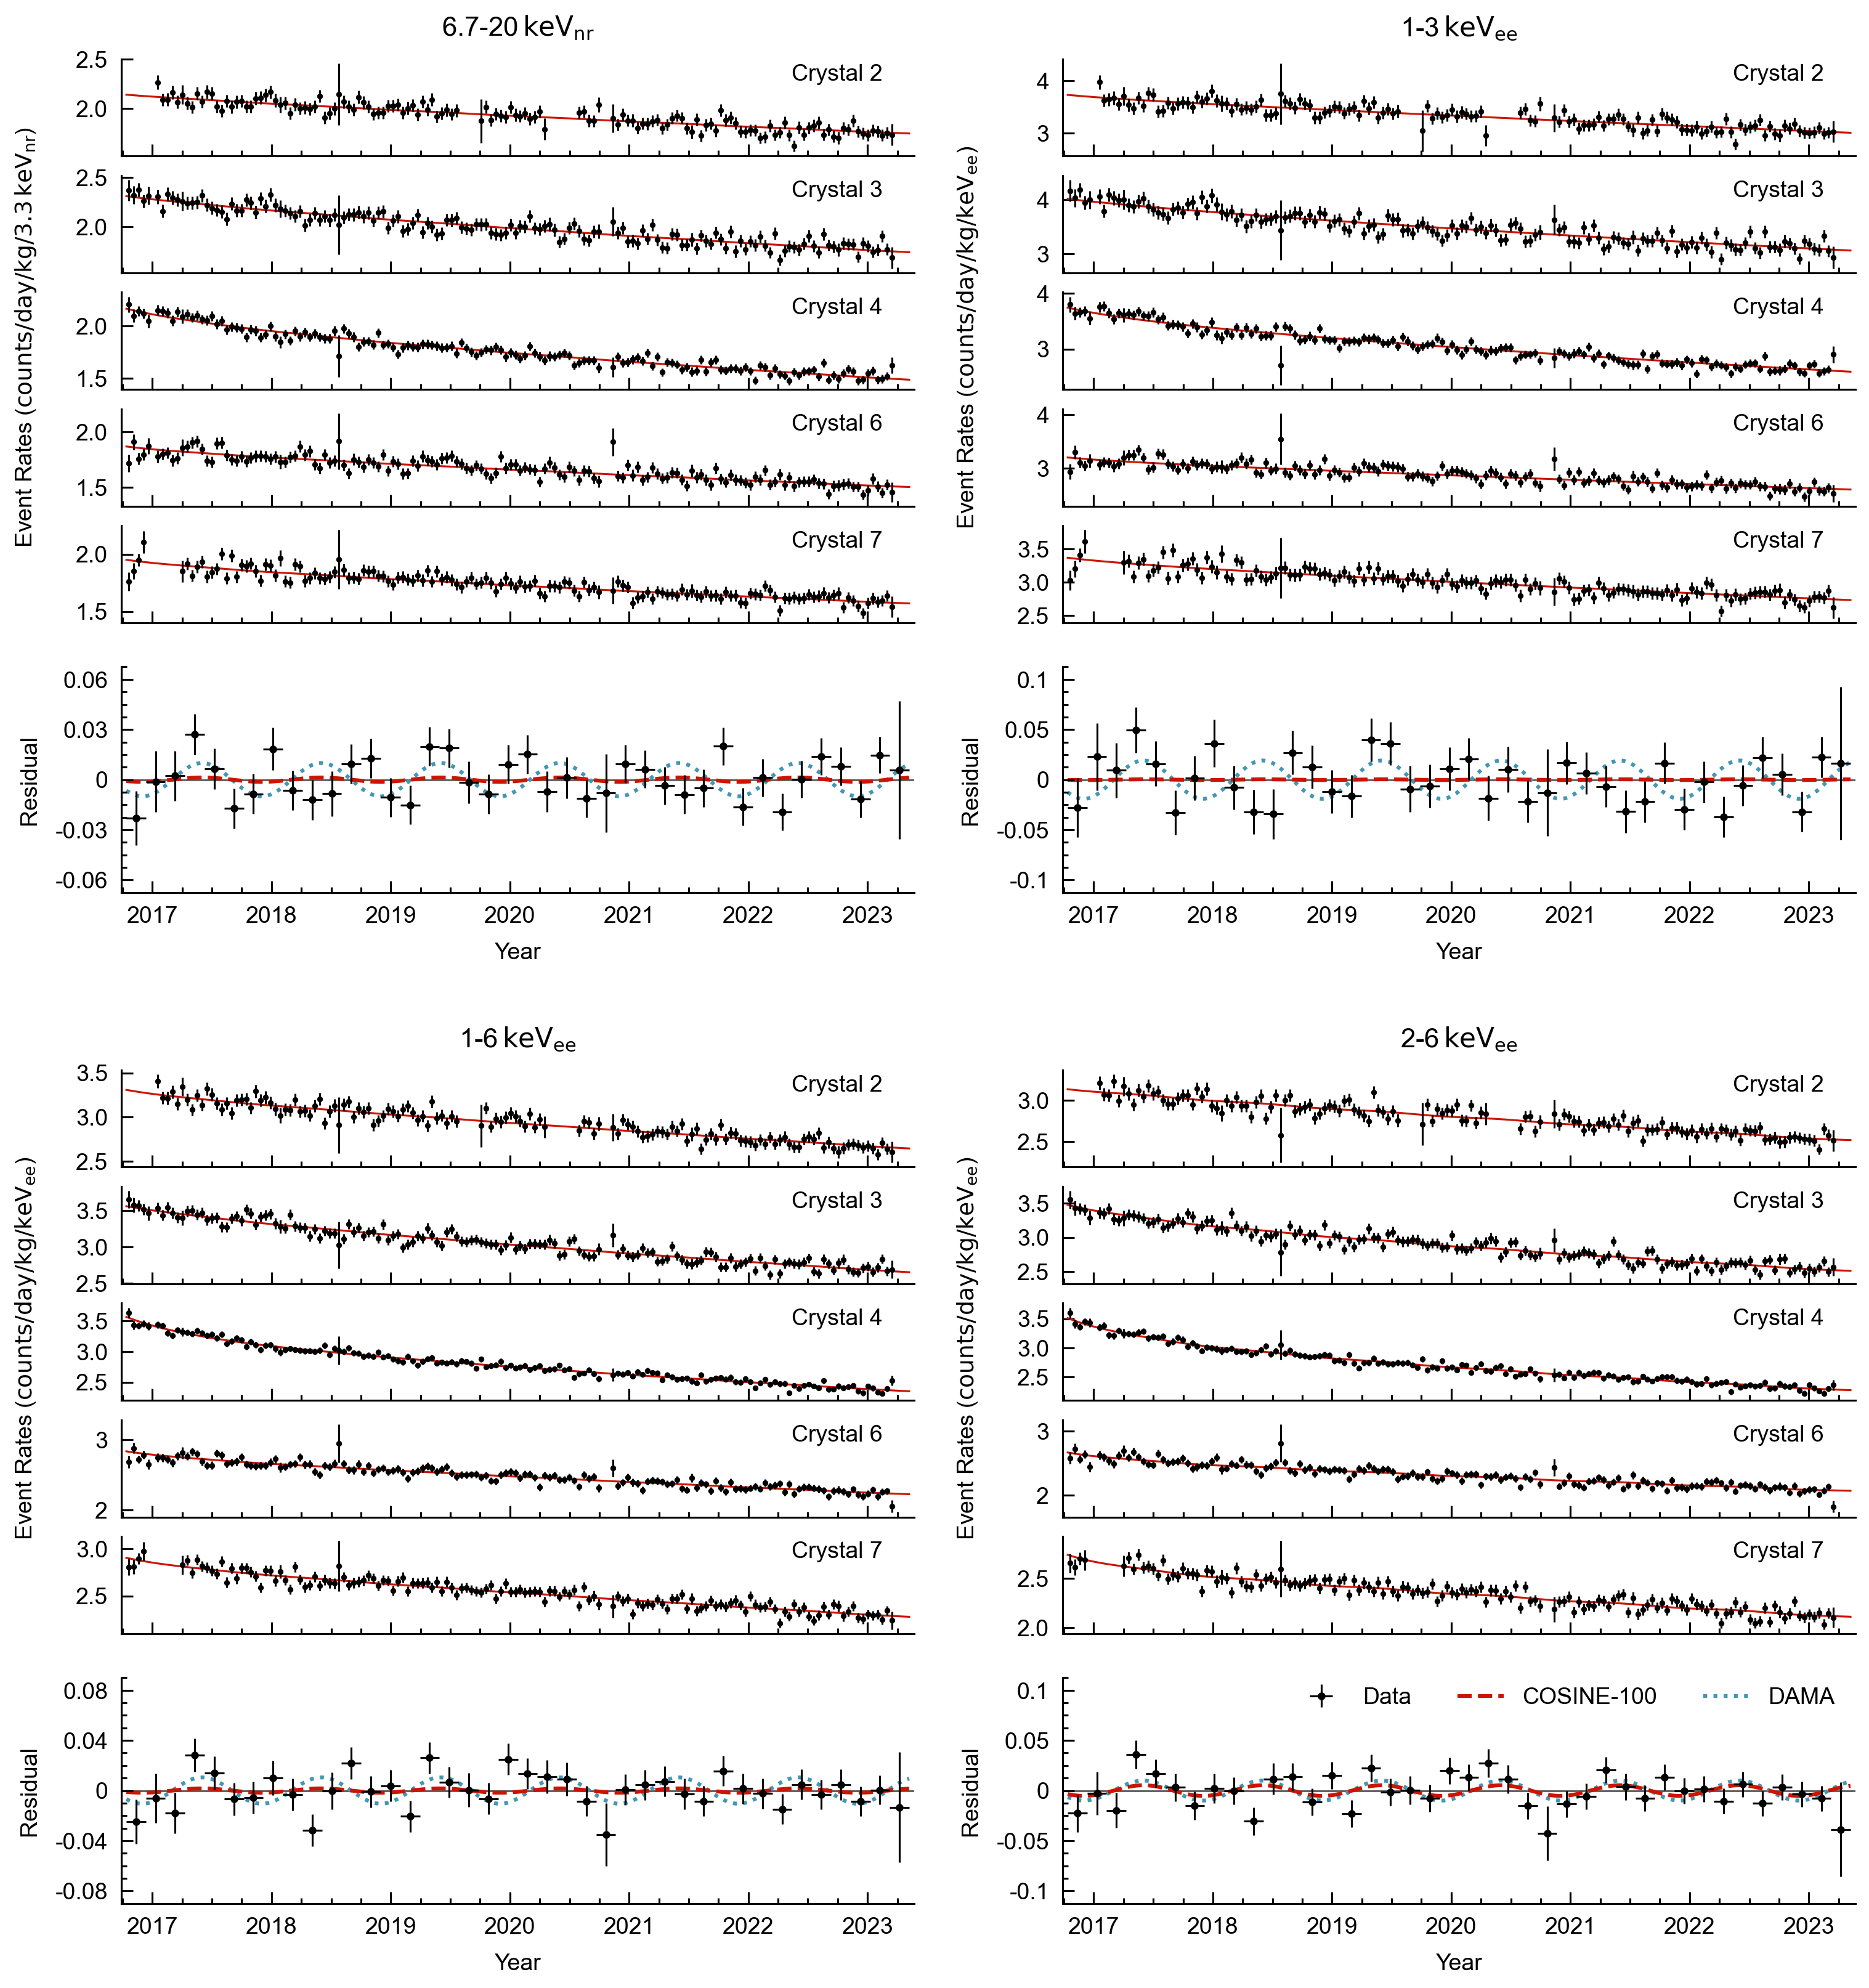

In [6]:
fig = plt.figure()

config_figs = fig.subfigures(2, len(configurations) // 2, wspace=-0.08, hspace=0.06)
for config_fig, (policy, energy_range) in zip(
    config_figs.flatten(), configurations
):
    print("Drawing...", policy, energy_range)

    # Subfigures
    rate_fig, residual_fig = config_fig.subfigures(
        2,
        1,
        height_ratios=[len(crystals), 2],
        wspace=0.0,
        hspace=-0.14,
    )
    rate_axs = rate_fig.subplots(len(crystals), 1)
    residual_ax = residual_fig.subplots(1, 1)

    # Read data
    event_rate_df = pd.read_csv(
        data_dir + f"EventRate_{policy}{energy_range}.csv"
    )
    background_df = pd.read_csv(
        data_dir + f"BackgroundRate_{policy}{energy_range}.csv"
    )

    # Convert axes
    event_rate_day_centers = event_rate_df["day_centers"].values
    event_rate_day_width = (
        event_rate_day_centers[1] - event_rate_day_centers[0]
    ) / 2

    background_day_centers = background_df["day_centers"]

    xlim = [
        min(
            event_rate_day_centers.min() - event_rate_day_width,
            background_day_centers.min(),
        )
        - 15,
        max(
            event_rate_day_centers.max() + event_rate_day_width,
            background_day_centers.max(),
        )
        + 15,
    ]

    days_on_max = np.arange(dama_phase, xlim[1], days_per_year)
    days_on_year = np.arange(0, xlim[1], days_per_year)
    year_labels = [f"{2016 + i}" for i in range(len(days_on_year))]
    days_minor_ticks = np.arange(0, xlim[1], days_per_year / 4)

    # Best-fit of COSINE-100
    cosine_modulation = cosine_amplitude[(policy, energy_range)][0] * np.cos(
        2 * np.pi * (background_day_centers - dama_phase) / days_per_year
    )

    # Draw event rates
    for crystal, ax in zip(crystals, rate_axs):
        event_rate = event_rate_df[f"event_rate_crystal{crystal}"].values
        event_rate_error = event_rate_df[
            f"event_rate_error_crystal{crystal}"
        ].values
        background = background_df[f"background_crystal{crystal}"].values

        best_fit = background + cosine_modulation

        ax.plot(background_day_centers, best_fit, color=colors["IbsRed"])
        ax.errorbar(
            event_rate_day_centers,
            event_rate,
            xerr=event_rate_day_width,
            yerr=event_rate_error,
            fmt=".",
            markersize=1,
            color="black",
        )

        # style
        ax.text(
            0.96,
            0.95,
            f"Crystal {crystal}",
            ha="right",
            va="top",
            transform=ax.transAxes,
        )

        ax.set_xticks(days_on_year)
        ax.set_xticklabels(list())
        ax.set_xticks(days_minor_ticks, minor=True)
        ax.set_xlim(xlim)
    rate_axs[0].set_title(configuration_titles[(policy, energy_range)])

    # Mean, rebinned residual
    ax = residual_ax
    mean_residual = event_rate_df["mean_residual"].values
    mean_residual_error = event_rate_df["mean_residual_error"].values

    mean_residual[np.isnan(mean_residual)] = 0.0

    rebin = 4
    mean_residual = mean_residual.reshape((-1, rebin))
    mean_residual_error = mean_residual_error.reshape((-1, rebin))
    mean_residual_weight = np.zeros_like(mean_residual_error)
    mean_residual_weight[
        ~np.isnan(mean_residual_error) & (mean_residual_error > 0.0)
    ] = (
        1
        / mean_residual_error[
            ~np.isnan(mean_residual_error) & (mean_residual_error > 0.0)
        ]
        ** 2
    )
    mean_residual = np.sum(
        mean_residual * mean_residual_weight, axis=1
    ) / np.sum(mean_residual_weight, axis=1)
    mean_residual_error = np.sqrt(1 / np.sum(mean_residual_weight, axis=1))

    residual_days = event_rate_day_centers.reshape((-1, rebin)).mean(axis=1)
    residual_day_width = residual_days[1] - residual_days[0]

    draw_data = ax.errorbar(
        residual_days,
        mean_residual,
        xerr=residual_day_width / 2,
        yerr=mean_residual_error,
        fmt=".",
        label="Data",
        color="black",
    )

    draw_background = ax.axhline(
        0.0, color=colors["IbsGrey"], label="Background", zorder=-3
    )

    draw_cosine = ax.plot(
        background_day_centers,
        cosine_modulation,
        color=colors["IbsRed"],
        linestyle="dashed",
        linewidth=1.0,
        label="COSINE-100",
        zorder=-1,
    )

    # Overlay DAMA modulation
    dama_claim = dama_amplitude[energy_range][0] * np.cos(
        2 * np.pi * (background_day_centers - dama_phase) / days_per_year
    )
    draw_dama = ax.plot(
        background_day_centers,
        dama_claim,
        color=colors["InfnBlue"],
        linestyle="dotted",
        linewidth=1.0,
        label="DAMA",
        zorder=-2,
    )

    # style
    if config_fig == config_figs.flatten()[-1]:
        handles = [draw_data, draw_cosine[0], draw_dama[0]]
        ax.legend(
            handles=handles,
            bbox_to_anchor=(1, 1.05),
            loc="upper right",
            frameon=False,
            ncol=3,
        )

    ax.set_xticks(days_on_year)
    ax.set_xticklabels(year_labels)
    ax.set_xticks(days_minor_ticks, minor=True)
    ax.set_xlim(xlim)
    ax.set_xlabel("Year")

    if policy == "nrc" and energy_range == "2-6":
        ax.set_ylim(-0.0675, 0.0675)
        ax.set_yticks([-0.06, -0.03, 0, 0.03, 0.06])
        ax.set_yticks(np.arange(-0.0675, 0.06751, 0.03 / 4), minor=True)
        ax.set_yticklabels(["-0.06", "-0.03", "0", "0.03", "0.06"])
    elif policy == "erc" and energy_range == "1-3":
        ax.set_ylim(-0.1125, 0.1125)
        ax.set_yticks([-0.10, -0.05, 0, 0.05, 0.10])
        ax.set_yticks(np.arange(-0.1125, 0.11251, 0.05 / 4), minor=True)
        ax.set_yticklabels(["-0.1", "-0.05", "0", "0.05", "0.1"])
    elif policy == "erc" and energy_range == "1-6":
        ax.set_ylim(-0.09, 0.09)
        ax.set_yticks([-0.08, -0.04, 0, 0.04, 0.08])
        ax.set_yticks(np.arange(-0.09, 0.09001, 0.04 / 4), minor=True)
        ax.set_yticklabels(["-0.08", "-0.04", "0", "0.04", "0.08"])
    elif policy == "erc" and energy_range == "2-6":
        ax.set_ylim(-0.1125, 0.1125)
        ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
        ax.set_yticks(np.arange(-0.1125, 0.11251, 0.05 / 4), minor=True)
        ax.set_yticklabels(["-0.1", "-0.05", "0", "0.05", "0.1"])

    if policy == "nrc":
        unit = r"($\mathrm{counts/day/kg/3.3 \, keV_{nr}}$)"
    else:
        unit = r"($\mathrm{counts/day/kg/keV_{ee}}$)"

    rate_fig.supylabel("Event Rates " + unit)
    ax.set_ylabel("Residual")

plt.savefig(figure_path)
plt.show()

## END-OF-NOTE